# Cluster Interview Test - Mateo Salles

##### Imports

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from matplotlib.colors import ListedColormap


#### Data Loading and Exploration

In [3]:
data = pd.read_csv('cluster_interview_test.csv')

In [4]:
data.head()

,user_id,total_saved_ever,no_of_manual+auto_saves,no_withdrawals,no_auto_saves,no_manual_saves,no_of_cancelled_autosaves,days_active
0,5804b63657135c14008b461f12,0.0,0,0,0,0,0,365
1,5815d07a84ab2011338b457764,0.0,0,0,0,0,8,404
2,586959e3a78c4b520e8b464626,0.0,0,0,0,0,2,22
3,58a6c4e1498b23c9028b45e668,0.0,0,0,0,0,6,190
4,58edfc494d19ee1c0000028627,0.0,0,0,0,0,2,180


All variables seem to be in reasonable data types. All numerical, only one continuous.

In [5]:
data.dtypes

user_id                       object
total_saved_ever             float64
no_of_manual+auto_saves        int64
no_withdrawals                 int64
no_auto_saves                  int64
no_manual_saves                int64
no_of_cancelled_autosaves      int64
days_active                    int64
dtype: object

ASSUMPTIONS: 

- TOTAL_SAVED_EVER is the variable of interest

- TOTAL_SAVED_EVER excludes withdrawals

- NO_AUTO_SAVES = NO_SUCCESFULL_AUTO_SAVES + NO_OF_CANCELLED_AUTO_SAVES ? (no, as NO_SUCCESFULL_AUTO_SAVES has negative values in that case)

#### Data Processing

Single entry per user

In [6]:
data.user_id.duplicated().any()

False

No missing values

In [7]:
data.isnull().values.any()

False

Normalize data with DAYS_ACTIVE

- this gives us features relative to user lifetime

In [8]:
cols_to_normalize = ['no_manual_saves', 'no_auto_saves', 'no_withdrawals', 'no_of_cancelled_autosaves']
new_col_names = ['%_manual_saves_per_day', '%_auto_saves_per_day', '%_withdrawals_per_day', '%_cancelled_autosaves_per_day']
for i in range(len(cols_to_normalize)):
    data[new_col_names[i]] = data[cols_to_normalize[i]] / data['days_active'] * 100

#### EDA

Descriptive statistics for numerical variables

In [9]:
data.describe()

,total_saved_ever,no_of_manual+auto_saves,no_withdrawals,no_auto_saves,no_manual_saves,no_of_cancelled_autosaves,days_active,%_manual_saves_per_day,%_auto_saves_per_day,%_withdrawals_per_day,%_cancelled_autosaves_per_day
count,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,1317.363305,50.65630,9.675100,44.877200,5.779100,5.488300,464.152400,1.264139,9.227027,2.326809,1.359481
std,1962.265495,35.89763,9.399477,30.610548,13.925318,9.226157,216.698309,2.902729,4.273840,2.218861,2.321229
min,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,8.000000,0.000000,0.000000,0.000000,0.000000
25%,249.607500,20.00000,3.000000,18.750000,0.000000,1.000000,351.000000,0.000000,6.060606,0.840336,0.178174
50%,728.480000,48.00000,7.000000,44.000000,1.000000,2.000000,482.500000,0.232019,9.966777,1.780619,0.520833
75%,1515.972500,74.00000,14.000000,66.000000,4.000000,6.000000,601.000000,0.990099,12.722385,3.189173,1.578169
max,21066.090000,233.00000,90.000000,153.000000,155.000000,186.000000,1086.000000,37.500000,37.500000,37.500000,57.446809


Plot histograms for numerical variables

In [10]:
def plot_histograms(data_frame):
    numeric_columns = data_frame.select_dtypes(include='number').columns
    num_cols = len(numeric_columns)
    num_rows = (num_cols - 1) // 3 + 1
    fig, axes = plt.subplots(num_rows, 3, figsize=(12, 4 * num_rows))
    if num_cols > 1:
        axes = axes.flatten()
    else:
        axes = [axes]
    for i, column in enumerate(numeric_columns):
        ax = axes[i]
        ax.hist(data[column], bins=20) 
        ax.set_title(column)
        ax.set_xlabel('Value')
        ax.set_ylabel('Frequency')
    if num_cols < len(axes):
        for j in range(num_cols, len(axes)):
            fig.delaxes(axes[j])
    fig.tight_layout()
    plt.show()

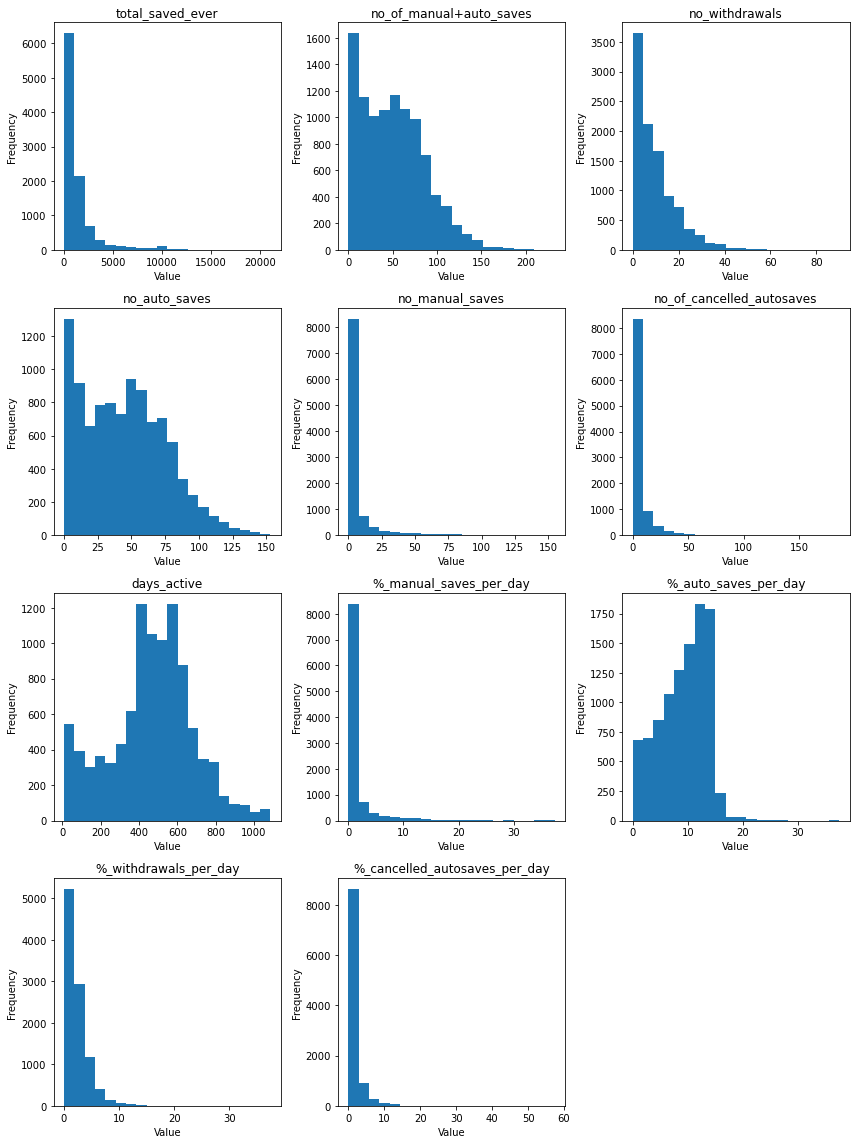

In [11]:
plot_histograms(data)

In general, users are more on the side of inactivity, as the variables we have show activity

In [14]:
print(len(data[data['total_saved_ever'] == 0]))

135


135 users have never saved money

    Let's check the correlation matrix

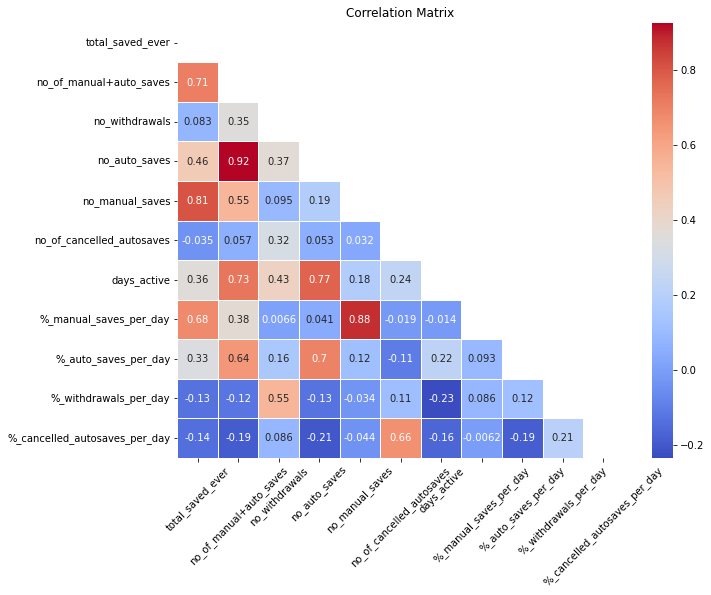

In [15]:
corr_matrix = data.corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, mask=mask, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()

TOTAL_SAVED_EVER

- positive correlation to NO_MANUAL_SAVES suggesting that the biggest savings are done manually

NO_OF_MANUAL+AUTO_SAVES 

- strongly correlated to NO_AUTO_SAVES, repetitive information

We have to drop all non-normalized variables, aswell as DAYS_ACTIVE the normilizing variable

    We will drop NO_OF_MANUAL+AUTO_SAVES as its information is in NO_AUTO_SAVES and NO_MANUAL_SAVES

In [16]:
data_0 = data.copy()

In [17]:
data = data_0.drop(columns=['no_of_manual+auto_saves', 'no_manual_saves', 'no_auto_saves', 'no_withdrawals', 'no_of_cancelled_autosaves', 'days_active'])

In [18]:
data.dtypes

user_id                           object
total_saved_ever                 float64
%_manual_saves_per_day           float64
%_auto_saves_per_day             float64
%_withdrawals_per_day            float64
%_cancelled_autosaves_per_day    float64
dtype: object

    Let's check the correlation matrix again after droping NO_OF_MANUAL+AUTO_SAVES

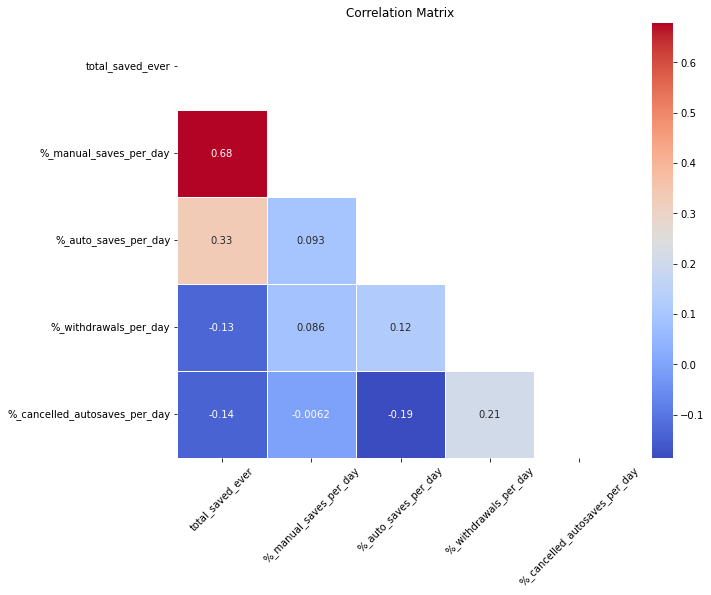

In [19]:
corr_matrix = data.corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, mask=mask, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()

TOTAL_SAVED_EVER 

- strong positive correlation to MANUAL_SAVES_PER_DAY suggesting that the biggest saves are done manually

- positive correlation AUTO_SAVES_PER_DAY

- small negative correlation to WITHDRAWALS_PER_DAY & CANCELLED_AUTOSAVES_PER_DAY
    - suggests that good savers also do withdrawals and cancel autosaves



<!-- DAYS_ACTIVE -->
    
<!-- - strong correlation to NO_AUTO_SAVES which makes sense, as auto saves are spread 'uniformily' over time

- positive correlation with every other variable -->

<!-- INTERESTING: -->

#### Clustering

K-MEANS

- fit: train the model with the data
- predict: new entry prediction
- plot_f_vs_tse: plot every feature against TSE
- describe_clusters: give the mean value of the feature for each cluster, as well as NO_USERS, TOTAL_SAVINGS
- calculate_wcss: calculate within-cluster sum of squares
- elbow_method: calculates and plots(optional) the wcss for all number of clusters until a max

In [20]:
class KMeansClustering:
    def __init__(self, n_clusters=5, seed=None):
        self.n_clusters = n_clusters
        self.seed = seed
        if self.seed != None:
            self.kmeans = KMeans(n_clusters=self.n_clusters, n_init=10, random_state=self.seed)
        else:
            self.kmeans = KMeans(n_clusters=self.n_clusters, n_init=10)
        
    def fit(self, data_np):
        self.kmeans.fit(data_np)
        
    def predict(self, data_np):
        return self.kmeans.predict(data_np)

    def plot_f_vs_tse(self, data_np, feature_names=[str(_) for _ in range(6)]):
        labels = self.kmeans.labels_
        centroids = self.kmeans.cluster_centers_
        num_clusters = len(set(labels))
        num_features = data_np.shape[1]
        colors = ['#5DC863', '#21908C', '#440154', '#3B528B', '#FDE725']
        fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))
        fig.subplots_adjust(hspace=0.4)
        plot_num = 1
        for i in range(1, num_features):
            for j in range(num_clusters):
                ax = axes[(i-1)//2, (i-1)%2]
                ax.scatter(data_np[labels == j, 0], data_np[labels == j, i], c=colors[j])
                ax.scatter(centroids[:, 0], centroids[:, i], marker='X', color='red', s=100)
                ax.set_xlabel(feature_names[0])
                ax.set_ylabel(feature_names[i])
                ax.set_title(f'{feature_names[0]} vs {feature_names[i]}')
                plot_num += 1
        plt.tight_layout()
        plt.show()
        
    def describe_clusters(self, data_np, feature_names=[str(_) for _ in range(6)]):
        labels = self.kmeans.labels_
        cluster_stats = pd.DataFrame(columns=feature_names)
        no_members, total_savings = [], []
        for label in range(self.n_clusters):
            cluster_data = data_np[labels == label]
            cluster_val = cluster_data[:, :len(feature_names)].mean(axis=0)
            cluster_stats.loc[f'Cluster {label+1}'] = cluster_val
            no_members.append(cluster_data.shape[0])
            total_savings.append(sum(cluster_data[:,0]))
        cluster_stats['no_users'] = no_members
        cluster_stats['total_savings'] = total_savings
        return cluster_stats
    
    def calculate_wcss(self, data_np):
        return np.sum((data_np - self.kmeans.cluster_centers_[self.kmeans.labels_]) ** 2)
    
    def elbow_method(self, data_np, max_clusters, plot = True):
        wcss_values = []
        for num_clusters in range(1, max_clusters + 1):
            self.n_clusters = num_clusters
            self.fit(data_np)
            wcss = self.calculate_wcss(data_np)
            wcss_values.append(wcss)
        if plot == True:
            plt.plot(range(1, max_clusters + 1), wcss_values, marker='o')
            plt.xlabel('Number of Clusters')
            plt.ylabel('WCSS')
            plt.title('Elbow Method')
            plt.show()
        return wcss_values.index(min(wcss_values))+1
    
    def evaluate_model(self, data_np):
        self.fit(data_np)
        wcss = self.calculate_wcss(data_np)
        n_samples, n_features = data_np.shape
        k = self.n_clusters
        aic = wcss + 2 * n_features * k
        bic = wcss + np.log(n_samples) * n_features * k
        labels = self.predict(data_np)
        silhouette = silhouette_score(data_np, labels)
        print("Evaluation Metrics:")
        print("Number of Clusters:", k)
        print("WCSS:", wcss)
        print("AIC:", aic)
        print("BIC:", bic)
        print("Silhouette Score:", silhouette)

Initiate the K-Means model

In [21]:
data_num = data.loc[:, data.columns != 'user_id']
feature_names = data_num.columns.values
data_np = data_num.to_numpy()
kmeans_clustering = KMeansClustering()

There is no obvious number of clusters. Even by running several iterations.

(for proof, run a couple of times the following cell)

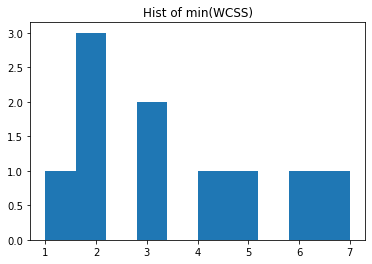

In [22]:
max_clusters=10
number_clusters = [kmeans_clustering.elbow_method(data_np, max_clusters, plot = False) for _ in range(10)]
plt.hist(number_clusters, bins = max_clusters)
plt.title('Hist of min(WCSS)')
plt.show()

    We will continue with 5 clusters

In [23]:
kmeans_clustering = KMeansClustering(n_clusters=5, seed=81)
kmeans_clustering.fit(data_np)
km_model = kmeans_clustering.kmeans

The evaluation of the model suggests that the clusters are relatively well defined
- not trivial to analyze WCSS, AIC and BIC on their own, it would help to compare to other clustering methods
- Silhouette score suggests fairly separated clusters

In [24]:
kmeans_clustering.evaluate_model(data_np)

Evaluation Metrics:
Number of Clusters: 5
WCSS: 2706747641.4618187
AIC: 2706747691.4618187
BIC: 2706747871.720328
Silhouette Score: 0.6044509896855162


The following plots of TOTAL_SAVED_EVER vs the other features suggest that the clustering is well grouped

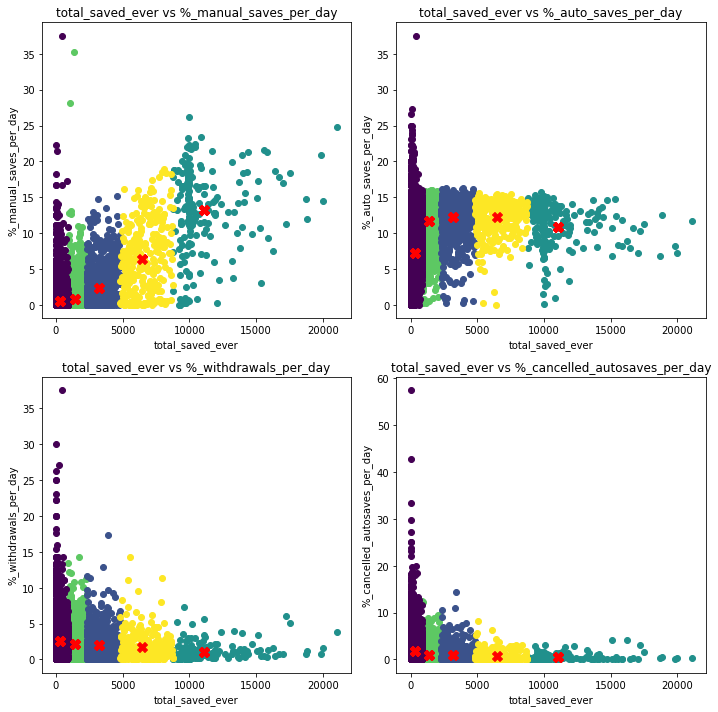

In [25]:
kmeans_clustering.plot_f_vs_tse(data_np, feature_names)

In [26]:
def plot_bars(df):
    num_cols = len(df.columns)
    labels = km_model.labels_
    num_rows = (num_cols + 1) // 2
    fig, axes = plt.subplots(nrows=num_rows, ncols=2, figsize=(10, 5*num_rows))
    colors = ['#440154', '#5DC863', '#3B528B', '#FDE725', '#21908C']
    colormap = ListedColormap(colors[:len(set(labels))])
    for i, column in enumerate(df.columns):
        ax = axes[i // 2, i % 2]
        bars = ax.bar(df.index, df[column], color=colormap(np.arange(len(df.index))))
        ax.set_xlabel("Index")
        ax.set_ylabel(column)
        ax.set_title(f"Bar of {column}")
    plt.tight_layout()
    plt.show()

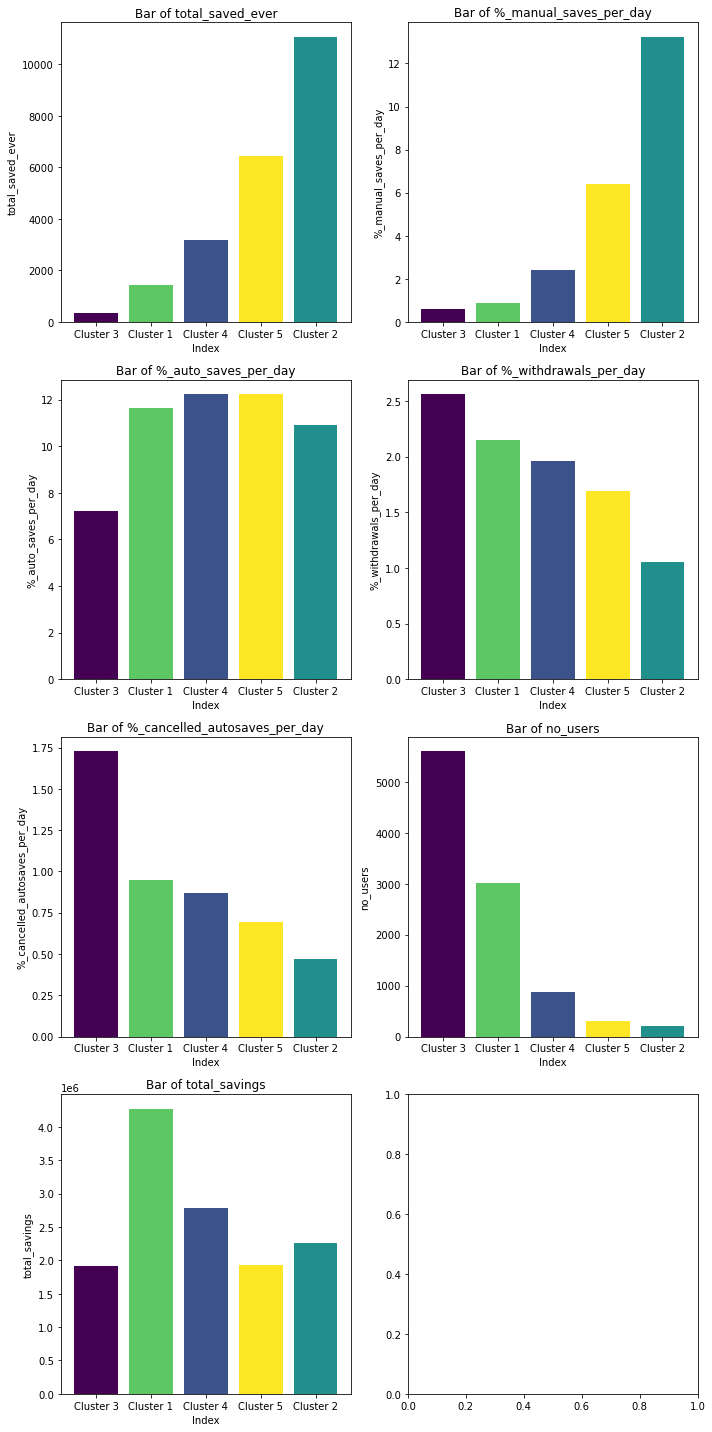

In [27]:
cluster_agg = kmeans_clustering.describe_clusters(data_np, feature_names)
cluster_agg = cluster_agg.sort_values(by=['total_saved_ever'])
plot_bars(cluster_agg)

#### Conclusions

FACTS:
- PURPLE cluster has 56% of total users and represents 14.50% of total savings
- GREEN cluster has 30.24% of users and represents 32.47% of total savings
- NAVY cluster has 8.72% of users and represents 21.16% of total savings

In [817]:
map_cluster_color = [('PURPLE', 3), ('GREEN', 1), ('NAVY', 4), ('YELLOW', 5), ('BLUE', 2)]
cluster_agg.index = [map_cluster_color[i][0] for i in range(len(map_cluster_color))]
cluster_agg['total_savings_%'] = cluster_agg['total_savings'] / cluster_agg['total_savings'].sum() * 100
cluster_agg

,total_saved_ever,%_manual_saves_per_day,%_auto_saves_per_day,%_withdrawals_per_day,%_cancelled_autosaves_per_day,no_users,total_savings,total_savings_%
PURPLE,341.367797,0.591564,7.237684,2.562477,1.727355,5602,1912342.40,14.516439
GREEN,1415.069080,0.863093,11.639196,2.145711,0.946012,3022,4276338.76,32.461347
NAVY,3197.744450,2.408389,12.223295,1.956559,0.868094,872,2788433.16,21.166774
YELLOW,6458.456867,6.390998,12.238491,1.693010,0.690710,300,1937537.06,14.707690
BLUE,11073.439559,13.243933,10.886544,1.052632,0.466322,204,2258981.67,17.147750


    ACTIONS:
    - Jump from PURPLE cluster to GREEN
        - How? targeting their auto_saves
    - Jump from GREEN cluster to NAVY
        - How? targeting their manual_saves

Further analysis can be done to analyze how TOTAL_SAVINGS could change by increasing PURPLE group's AUTO_SAVES and GREEN group's MANUAL_SAVES. 

For example: a simple multivariate linear model.